# <center>Proyecto Integrador
# <center>MYSQL & PYTHON Datos Mundiales

## Sección 2: Conexión a MySQL desde Python

In [8]:
import os
from pathlib import Path
import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

import mysql.connector
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
from dotenv import load_dotenv

In [9]:
# Cargar variables desde el archivo .env
env_path = Path().resolve() / ".env"
load_dotenv(dotenv_path=env_path)

# Recuperar valores desde el entorno
usuario = os.getenv("MYSQL_USER")
clave = os.getenv("MYSQL_PASSWORD")
host = os.getenv("MYSQL_HOST")
bd = os.getenv("MYSQL_DB")

# Crear el motor de conexión
engine = create_engine(f"mysql+pymysql://{usuario}:{clave}@{host}/{bd}")

In [10]:
# Se crea una función para ejecutar consultas

def ejecutar_query(query, engine):
    df = pd.read_sql(query, con=engine)
    df.index = df.index + 1
    return df

### Ejercicios

### Ejercicio 1: Escribe una consulta para mostrar el nombre y la población de todos los países del continente europeo.

In [44]:
query = """
SELECT country_name, population
FROM country
WHERE continent = 'Europe';
"""
df_ej1 = ejecutar_query(query, engine)
df_ej1


,country_name,population
1,Albania,3401200
2,Andorra,78000
3,Austria,8091800
4,Belgium,10239000
5,Bulgaria,8190900
6,Bosnia and Herzegovina,3972000
7,Belarus,10236000
8,Switzerland,7160400
9,Czech Republic,10278100
10,Germany,82164700


### Ejercicio 2: Escribe una consulta para mostrar los nombres y las áreas de superficie de los cinco países más grandes del mundo (en términos de área de superficie).

In [13]:
query = """
SELECT country_name, surface_area
FROM country
ORDER BY surface_area DESC
LIMIT 5;
"""
df_ej2 = ejecutar_query(query, engine)
df_ej2


,country_name,surface_area
1,Russian Federation,17075400.0
2,Antarctica,13120000.0
3,Canada,9970610.0
4,China,9572900.0
5,United States,9363520.0


### Ejercicio 3: Escribe una consulta para calcular la población total de todos los países de cada continente y mostrar el resultado junto con el nombre del continente.

In [15]:
query = """
SELECT continent, SUM(population) AS total_population
FROM country
GROUP BY continent
ORDER BY total_population DESC;
"""
df_ej3 = ejecutar_query(query, engine)
df_ej3["total_population"] = df_ej3["total_population"].astype("int64")
df_ej3


,continent,total_population
1,Asia,3927467700
2,Africa,784475000
3,Europe,730074600
4,North America,482993000
5,South America,345780000
6,Oceania,30401150
7,Antarctica,0


### Ejercicio 4: Escribe una consulta para mostrar el nombre de las ciudades y la población de todos los países de Europa, ordenados por población de la ciudad de manera descendente.

In [16]:
query = """
SELECT
  ci.city_name   AS city,
  ci.population,
  co.country_name AS country
FROM city ci
LEFT JOIN country co ON ci.country_code = co.code
WHERE co.continent = 'Europe'
ORDER BY ci.population DESC;
"""
df_ej4 = ejecutar_query(query, engine)
df_ej4


,city,population,country
1,Moscow,8389200,Russian Federation
2,London,7285000,United Kingdom
3,St Petersburg,4694000,Russian Federation
4,Berlin,3386667,Germany
5,Madrid,2879052,Spain
...,...,...,...
837,Serravalle,4802,San Marino
838,San Marino,2294,San Marino
839,Longyearbyen,1438,Svalbard and Jan Mayen
840,Monaco-Ville,1234,Monaco


### Ejercicio 5: Actualiza la población de China (código de país 'CHN') a 1500000000 (1.5 mil millones).

In [20]:
# Guardamos el valor original para no dejar la base modificada
query_original = "SELECT population FROM country WHERE code = 'CHN';"
original = int(ejecutar_query(query_original, engine).iloc[0, 0])

try:
    # Subimos población a modo demo
    query_update = "UPDATE country SET population = :p WHERE code = 'CHN';"
    with engine.begin() as conn:
        conn.execute(text(query_update), {"p": 1_500_000_000})

    # Chequeo
    df_ej5 = ejecutar_query("SELECT code, country_name, population FROM country WHERE code='CHN';", engine)
    display(df_ej5)

finally:
    # Revertimos al valor original
    with engine.begin() as conn:
        conn.execute(text(query_update), {"p": original})

# Verificación final
ejecutar_query("SELECT code, country_name, population FROM country WHERE code='CHN';", engine)


,code,country_name,population
1,CHN,China,1500000000


,code,country_name,population
1,CHN,China,1277558000


### Helpers de gráficos


In [25]:
def plot_bar(df, x, y, title, xlabel=None, ylabel=None, horizontal=False):
    try:
        if horizontal:
            df.set_index(x)[y].plot(kind="barh")
        else:
            df.plot(kind="bar", x=x, y=y, legend=False)
        plt.title(title)
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Error al graficar barra: {e}")

def plot_hist(series, bins, title, xlabel=None):
    try:
        series.plot(kind="hist", bins=bins)
        plt.title(title)
        if xlabel: plt.xlabel(xlabel)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Error al graficar histograma: {e}")

def plot_scatter(df, x, y, title, xlabel=None, ylabel=None, log_xy=False):
    try:
        plt.scatter(df[x], df[y])
        if log_xy:
            plt.xscale("log"); plt.yscale("log")
        plt.title(title)
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Error al graficar scatter: {e}")


### Ejercicio 6: Consulta los idiomas oficiales en Sudamérica y gráfica cuántos países comparten cada idioma oficial.

In [40]:
query = """
SELECT
    cl.language,
    COUNT(*) AS num_countries
FROM country_language cl
LEFT JOIN country co ON cl.country_code = co.code
WHERE co.continent = 'South America' AND cl.is_official = 'T'
GROUP BY cl.language
ORDER BY num_countries DESC;
"""
df_ej6 = ejecutar_query(query, engine)
df_ej6


,language,num_countries
1,Spanish,9
2,Aimará,2
3,Ketšua,2
4,Portuguese,1
5,English,1
6,Guaraní,1


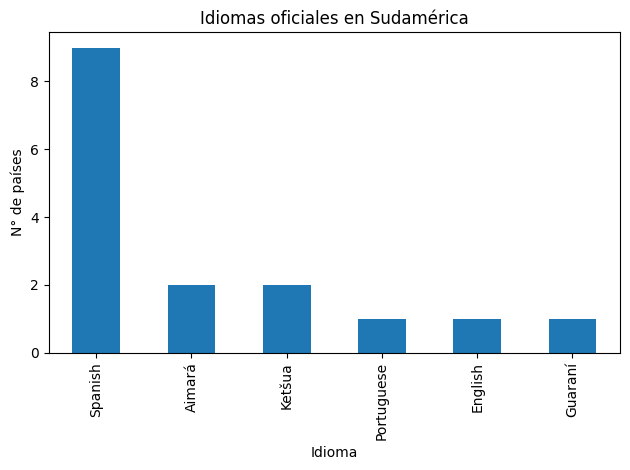

In [41]:
plot_bar(df_ej6,
         x="language",
         y="num_countries",
         title="Idiomas oficiales en Sudamérica",
         xlabel="Idioma",
         ylabel="N° de países")
    

### Ejercicio 7: Obtén todos los países con esperanza de vida > 75 años y crea un histograma de su distribución.

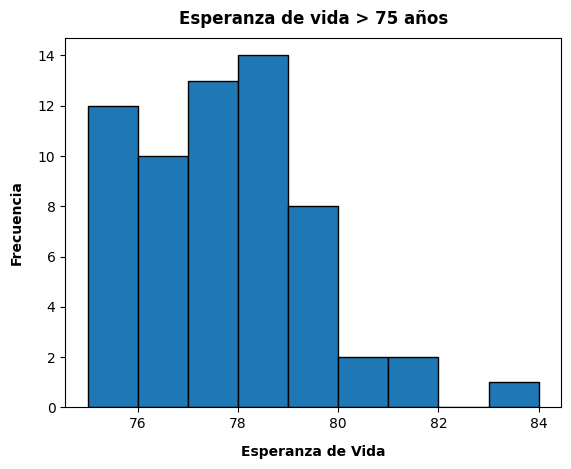

In [31]:
query = """
SELECT country_name AS country, life_expectancy
FROM country
WHERE life_expectancy > 75
ORDER BY life_expectancy DESC;
"""
df_ej7 = ejecutar_query(query, engine)
df_ej7.head()

plt.hist(df.life_expectancy, bins = range(75,85), edgecolor = "black")
plt.xlabel("Esperanza de Vida", labelpad = 10, fontweight='bold')
plt.ylabel("Frecuencia", labelpad = 10, fontweight='bold')
plt.title("Esperanza de vida > 75 años", pad = 10, fontweight='bold');


### Ejercicio 8: Calcula la densidad poblacional de todos los países y muestra un gráfico de dispersión entre superficie y población con el color como función del continente.

In [35]:
query = """
SELECT
    country_name AS country,
    population,
    surface_area,
    (population / surface_area) AS density,
    continent
FROM country
WHERE population > 0 AND surface_area > 0
ORDER BY density DESC;
"""
df_ej8 = ejecutar_query(query, engine)
df_ej8


,country,population,surface_area,density,continent
1,Macao,473000,18.0,26277.7778,Asia
2,Monaco,34000,1.5,22666.6667,Europe
3,Hong Kong,6782000,1075.0,6308.8372,Asia
4,Singapore,3567000,618.0,5771.8447,Asia
5,Gibraltar,25000,6.0,4166.6667,Europe
...,...,...,...,...,...
228,Western Sahara,293000,266000.0,1.1015,Africa
229,Pitcairn,50,49.0,1.0204,Oceania
230,Falkland Islands,2000,12173.0,0.1643,South America
231,Svalbard and Jan Mayen,3200,62422.0,0.0513,Europe


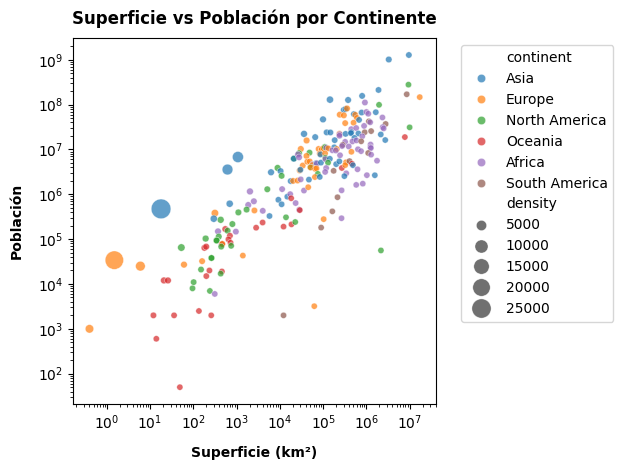

In [47]:
sns.scatterplot(data=df_ej8, x="surface_area", y="population", hue="continent", size="density", sizes=(20, 200), alpha=0.7)

plt.xscale('log')  
plt.yscale('log')
plt.title("Superficie vs Población por Continente", pad=10, fontweight='bold')
plt.xlabel("Superficie (km²)", labelpad=10, fontweight='bold')
plt.ylabel("Población", labelpad=10, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout();


### Ejercicio 9: Visualiza las ciudades con más de 5 millones de habitantes en un gráfico horizontal de barras.

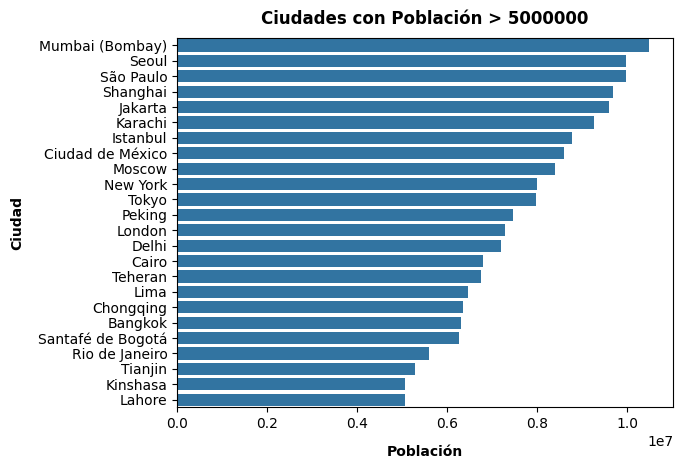

In [48]:
query = """
SELECT city_name AS city, population
FROM city
WHERE population > 5000000
ORDER BY population DESC;
"""
df_ej9 = ejecutar_query(query, engine)
df_ej9

sns.barplot(data=df_ej9, x="population", y="city", orient="h")
plt.title("Ciudades con Población > 5000000", pad=10, fontweight='bold')
plt.xlabel("Población", labelpad=10, fontweight='bold')
plt.ylabel("Ciudad", labelpad=10, fontweight='bold');


### Ejercicio 10: Gráfica cuántos idiomas se hablan por continente usando un gráfico de pastel.

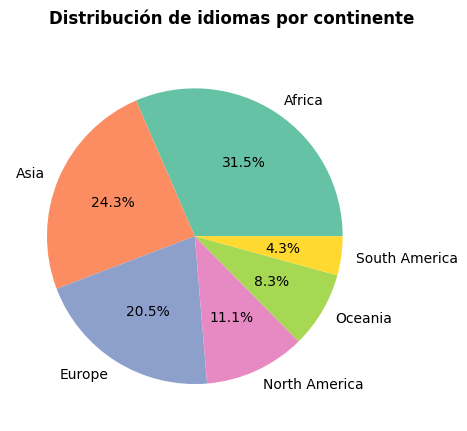

In [50]:
query = """
SELECT
    co.continent,
    COUNT(cl.language) AS num_languages
FROM country_language cl
LEFT JOIN country co ON cl.country_code = co.code
GROUP BY co.continent
ORDER BY num_languages DESC;
"""
df_ej10 = ejecutar_query(query, engine)
df_ej10

plt.pie(df_ej10["num_languages"], labels=df_ej10["continent"], autopct="%1.1f%%", colors=plt.cm.Set2.colors)
plt.title("Distribución de idiomas por continente", fontweight='bold', loc='center', pad=20, x=0.6);


## Sección 3: Análisis Estadístico

### Distribución de esperanza de vida

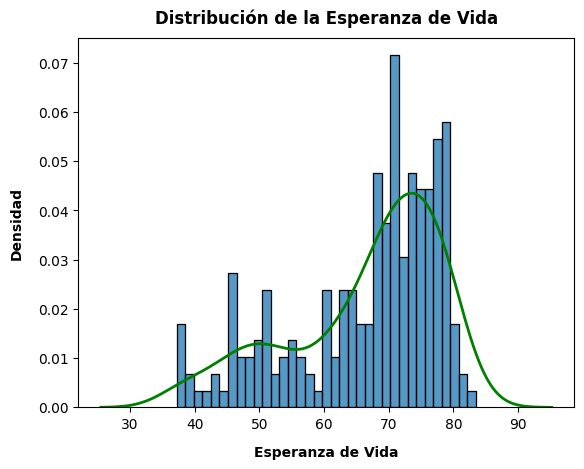

In [22]:
query = """
SELECT * 
FROM country
"""

df = ejecutar_query(query, engine)

sns.histplot(df["life_expectancy"], bins=35, stat="density")
sns.kdeplot(df["life_expectancy"], color="green", linewidth=2)
plt.title("Distribución de la Esperanza de Vida", pad=10, fontweight='bold')
plt.xlabel("Esperanza de Vida", labelpad=10, fontweight='bold')
plt.ylabel("Densidad", labelpad=10, fontweight='bold');


### Población total por continente

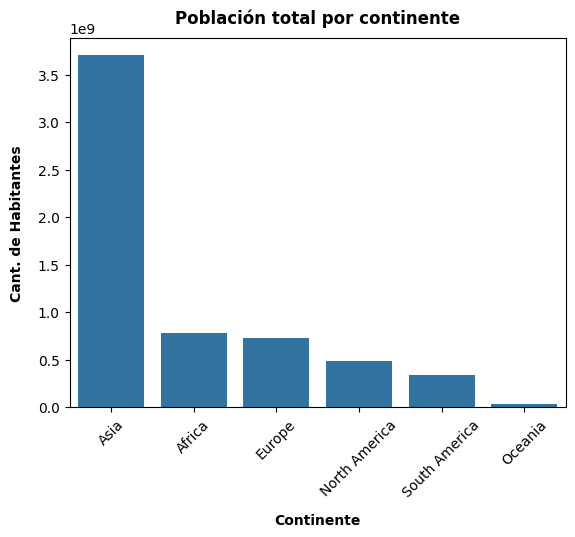

In [53]:
query = """
SELECT 
    continent, 
    SUM(population) AS num_population 
FROM country 
WHERE population != 0 
GROUP BY continent 
ORDER BY num_population DESC
"""

df_pob_total = ejecutar_query(query, engine)
df_pob_total["num_population"] = df_pob_total["num_population"].astype(int)

sns.barplot(data=df, x="continent", y="num_population")
plt.xlabel("Continente", labelpad=10, fontweight='bold')
plt.ylabel("Cant. de Habitantes", labelpad=10, fontweight='bold')
plt.xticks(rotation=45)
plt.title("Población total por continente", pad=10, fontweight='bold');


### Correlación entre superficie, población y esperanza de vida

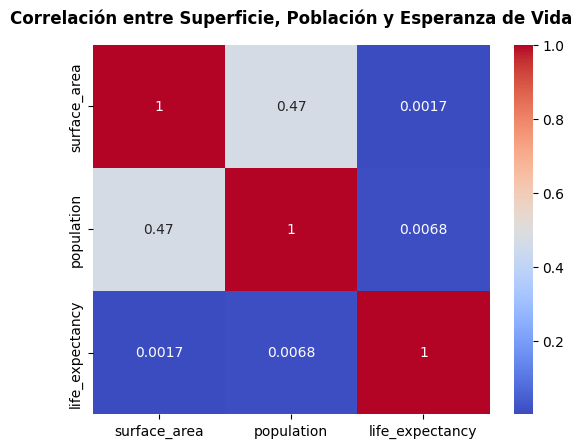

In [54]:
query = """
SELECT 
    country_name AS country,
    surface_area,
    population,
    life_expectancy,
    continent
FROM country
WHERE surface_area > 0 AND population > 0 AND life_expectancy IS NOT NULL
"""

df_corr_spev = ejecutar_query(query, engine)

correlacion = df_corr_spev[["surface_area", "population", "life_expectancy"]].corr()

sns.heatmap(correlacion, annot=True, cmap="coolwarm")
plt.title("Correlación entre Superficie, Población y Esperanza de Vida", pad=15, fontweight='bold');


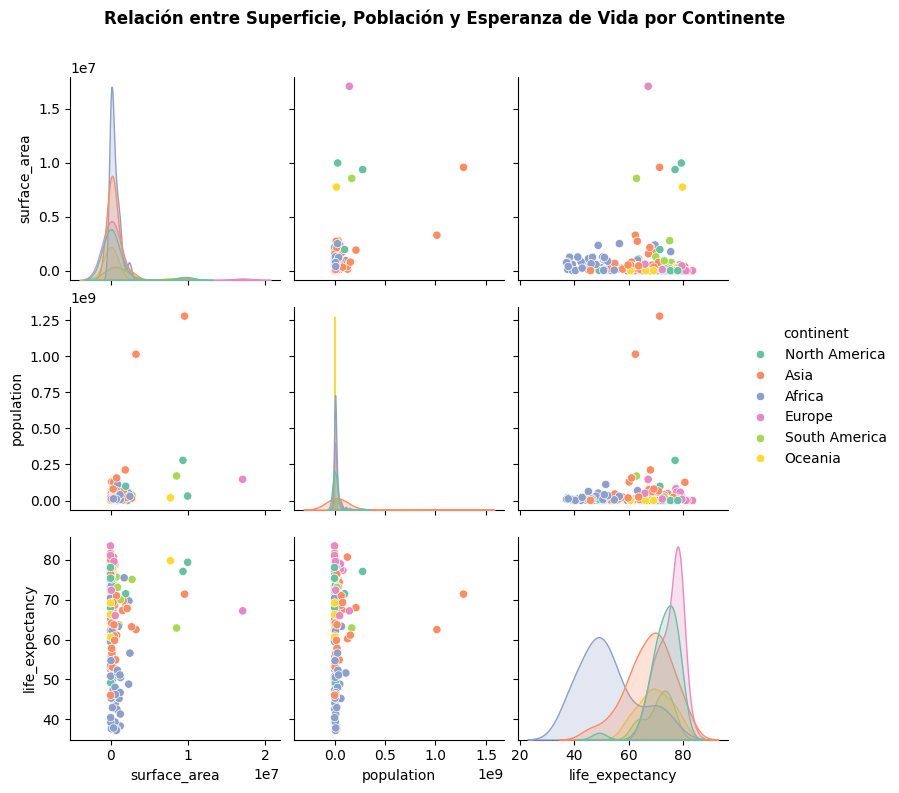

In [55]:
sns.pairplot(df_corr_spev, vars=["surface_area", "population", "life_expectancy"], hue="continent", palette="Set2")

plt.suptitle("Relación entre Superficie, Población y Esperanza de Vida por Continente", y=1.05, fontweight='bold');


### Top países por densidad poblacional y menor esperanza de vida

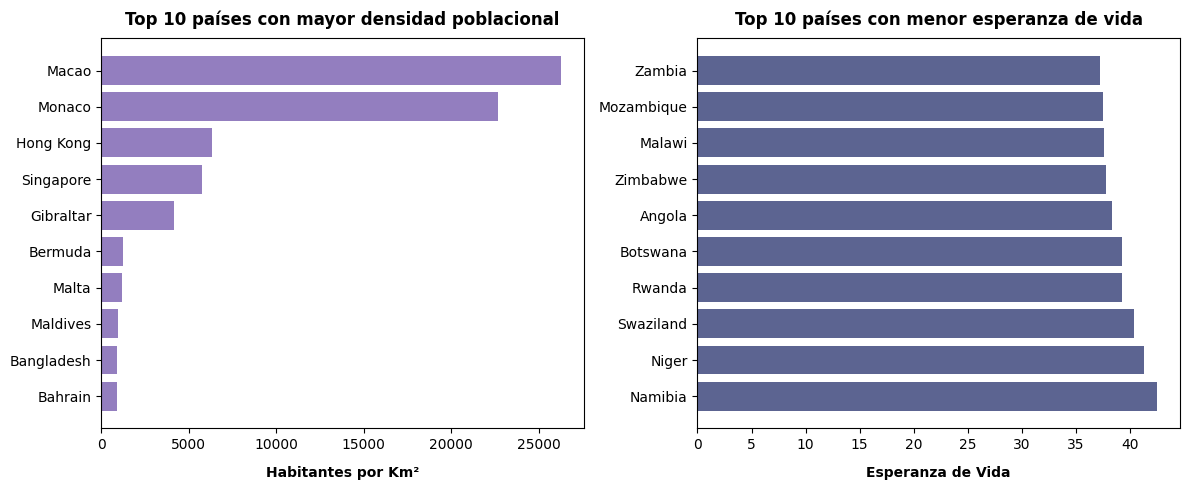

In [56]:
query = """
SELECT 
    country_name AS country,
    population,
    surface_area,
    life_expectancy,
    (population / surface_area) AS density
FROM country
WHERE surface_area > 0 AND population > 0 AND life_expectancy IS NOT NULL 
"""

df_top_dpev = ejecutar_query(query, engine)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

#Top 10 países con mayor densidad
top_Density = df_top_dpev.sort_values("density", ascending=False).head(10)
axes[0].barh(top_Density["country"], top_Density["density"],color="#937EBF")
axes[0].set_title("Top 10 países con mayor densidad poblacional", pad=10, fontweight='bold')
axes[0].set_xlabel("Habitantes por Km²", labelpad=10, fontweight='bold')
axes[0].invert_yaxis()

#Top 10 países con menor esperanza de vida
top_LifeExpectancy = df_top_dpev.sort_values("life_expectancy").head(10)
axes[1].barh(top_LifeExpectancy["country"], top_LifeExpectancy["life_expectancy"], color="#5C6491")
axes[1].set_title("Top 10 países con menor esperanza de vida", pad=10, fontweight='bold')
axes[1].set_xlabel("Esperanza de Vida", labelpad=10, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout();
